In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import os
from pathlib import Path

from requests import get
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, log_loss

import logging

logging.basicConfig(level=logging.WARN)

<IPython.core.display.Javascript object>

In [3]:
import os
import random
from tensorflow.random import set_seed

SEED = 42

os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
set_seed(SEED)

<IPython.core.display.Javascript object>

In [4]:
from tensorflow.keras import Model, Input
from tensorflow.keras.utils import plot_model, model_to_dot
from tensorflow.keras.layers import (
    Conv1D,
    SpatialDropout1D,
    LocallyConnected1D,
    Dense,
    Reshape,
    MaxPooling1D,
    BatchNormalization,
    Activation,
    LayerNormalization,
    Concatenate
)

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

from tensorflow_addons.activations import mish
from tensorflow_addons.optimizers import RectifiedAdam, Lookahead
from tensorflow_addons.layers import WeightNormalization

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder


from itertools import repeat
from concurrent.futures import ProcessPoolExecutor as PoolExecutor

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline


<IPython.core.display.Javascript object>

In [5]:
import tensorflow_addons as tfa

<IPython.core.display.Javascript object>

In [6]:
def word_to_np_array(word, cut_length):
    result = np.zeros(cut_length, dtype="uint8")
    for i, letter in enumerate(word[:cut_length]):
        result[i] = ord(letter)
    return result

<IPython.core.display.Javascript object>

In [7]:
def line_to_img(line, cut_length):
    result = np.zeros((line.shape[0], cut_length), dtype="uint8")
    for i in range(line.shape[0]):
        result[i] = word_to_np_array(line[i], cut_length)
    return result

<IPython.core.display.Javascript object>

In [8]:
def do_parallel_numpy(map_func, iter_params, constant_params=None):
    repeated_params = (
        [] if constant_params is None else list(map(repeat, constant_params))
    )
    results = None
    with PoolExecutor() as executor:
        results = np.stack(
            list(executor.map(map_func, *iter_params, *repeated_params)), axis=0
        )
    return results

<IPython.core.display.Javascript object>

In [9]:
def download(url, out, force=False, verify=True):
    out.parent.mkdir(parents=True, exist_ok=True)
    if force and out.exists():
        print(f"Removing file at {str(out)}")
        out.unlink()

    if out.exists():
        print("File already exists.")
        return
    print(f"Downloading {url} at {str(out)} ...")
    # open in binary mode
    with out.open(mode="wb") as file:
        # get request
        response = get(url, verify=verify)
        for chunk in response.iter_content(100000):
            # write to file
            file.write(chunk)


<IPython.core.display.Javascript object>

In [10]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if "loss" in s and "val" not in s]
    val_loss_list = [s for s in history.history.keys() if "loss" in s and "val" in s]
    acc_list = [s for s in history.history.keys() if "AUC" in s and "val" not in s]
    val_acc_list = [s for s in history.history.keys() if "AUC" in s and "val" in s]

    if len(loss_list) == 0:
        print("Loss is missing in history")
        return

    ## As loss always exists
    epochs = range(1, len(history.history[loss_list[0]]) + 1)

    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(
            epochs,
            history.history[l],
            "b",
            label="Training loss ("
            + str(str(format(history.history[l][-1], ".5f")) + ")"),
        )
    for l in val_loss_list:
        plt.plot(
            epochs,
            history.history[l],
            "g",
            label="Validation loss ("
            + str(str(format(history.history[l][-1], ".5f")) + ")"),
        )

    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

<IPython.core.display.Javascript object>

In [11]:
UNKNOWN_VALUE = ["Unkn0wnV@lue"]


class SafeLabelEncoder(LabelEncoder):
    """
    Safe label encoder, encoding every unknown value as Unkn0wnV@lue.
    """

    def fit(self, y):
        """
        Fit the label encoder, by casting the numpy array as a string, then adding the code for unknown.
        
        Parameters
        ----------
        y : numpy array
            the values to fit
        
        Returns
        -------
        SafeLabelEncoder
            itself, fitted
        """
        return super().fit(np.concatenate((y.astype("str"), UNKNOWN_VALUE)))

    def fit_transform(self, y):
        """
        Fit the encoder, then transform the input data and returns it.
        
        Parameters
        ----------
        y : numpy array
            the values to fit
        
        Returns
        -------
        numpy array
            the encoded data
        """
        self.fit(y)
        return super().transform(y)

    def transform(self, y):
        """
        Transform the input data and returns it.
        
        Parameters
        ----------
        y : numpy array
            the values to fit
        
        Returns
        -------
        numpy array
            the encoded data
        """
        return super().transform(
            np.where(
                np.isin(y.astype("str"), self.classes_), y.astype("str"), UNKNOWN_VALUE
            )
        )


<IPython.core.display.Javascript object>

In [12]:
dataset_name = "bank-marketing"
filename = "train_bench.csv"
target = "y"
ids = []

<IPython.core.display.Javascript object>

dataset_name = "rl"
filename = "train_bench.csv"
target = "target"
ids = []

In [13]:
dataset_name = "open-payments"
filename = "train_bench.csv"
target = "status"
ids = []

<IPython.core.display.Javascript object>

In [14]:
dataset_name = "give-me-some-credit"
filename = "train_bench.csv"
target = "SeriousDlqin2yrs"
ids = ["Unamed"]

<IPython.core.display.Javascript object>

In [15]:
out = Path(os.getcwd()) / "data" / dataset_name / filename

<IPython.core.display.Javascript object>

In [16]:
train = pd.read_csv(out)
train.shape

(150000, 13)

<IPython.core.display.Javascript object>

In [17]:
if "Set" not in train.columns:
    print("Building tailored column")
    train_valid_index, test_index = next(
        StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=SEED).split(
            range(train[target].shape[0]), train[target].values
        )
    )
    train_index, valid_index = next(
        StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=SEED).split(
            train_valid_index, train[target].values[train_valid_index]
        )
    )
    train["Set"] = "train"
    train["Set"][valid_index] = "valid"
    train["Set"][test_index] = "test"
    # train.to_csv((out.parent / "train_bench.csv").as_posix(), index=False)

<IPython.core.display.Javascript object>

In [18]:
train_indices = train[train.Set == "train"].index
valid_indices = train[train.Set == "valid"].index
test_indices = train[train.Set == "test"].index

<IPython.core.display.Javascript object>

In [19]:
big_ids = train.columns[train.dtypes != "object"][
    (np.sum(train[train.columns[train.dtypes != "object"]] > 1e15) > 0)
].tolist()
print(len(big_ids))
big_ids

0


[]

<IPython.core.display.Javascript object>

In [20]:
train[big_ids] = train[big_ids].astype("str")

<IPython.core.display.Javascript object>

In [21]:
cat_cols = list(
    set(
        train.columns[
            (
                (
                    train[train["Set"] != "test"].nunique()
                    / train[train["Set"] != "test"].shape[0]
                )
                < 0.05
            )
            & (train.dtypes != "object")
        ].tolist()
    )
    - set([target])
)
cat_cols

['NumberOfTime30-59DaysPastDueNotWorse',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'NumberOfTimes90DaysLate',
 'age',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberRealEstateLoansOrLines',
 'NumberOfDependents']

<IPython.core.display.Javascript object>

In [22]:
# train[cat_cols] = train[cat_cols].astype("str")

<IPython.core.display.Javascript object>

In [23]:
constant_cols = train.columns[train.nunique() <= 1]
constant_cols

Index([], dtype='object')

<IPython.core.display.Javascript object>

In [24]:
n_unique = train.nunique()

<IPython.core.display.Javascript object>

In [25]:
bool_cols = train.columns[n_unique == 2]
bool_cols = list(set(bool_cols.tolist()) - set([target]) - set(["Set"]))
bool_cols

[]

<IPython.core.display.Javascript object>

In [26]:
bool_encoder = {}

<IPython.core.display.Javascript object>

In [27]:
for col in bool_cols:
    enc = SafeLabelEncoder()
    enc.fit(train[col].values[train_indices].astype("str").reshape(-1))
    train[col] = enc.transform(train[col].values.astype("str").reshape(-1))
    bool_encoder[col] = enc

<IPython.core.display.Javascript object>

In [28]:
constant_cols = train.columns[n_unique <= 1]
constant_cols = list(set(constant_cols.tolist()) - set([target]) - set(["Set"]))
constant_cols

[]

<IPython.core.display.Javascript object>

In [29]:
ratio = 0.05  #  This means we consider this a category if 1000 elt, there is at most 50 different values

<IPython.core.display.Javascript object>

In [30]:
def format_number(nb):
    if not np.isfinite(nb):
        return str(nb)
    return np.format_float_scientific(
        nb, precision=9, unique=False, pad_left=None, exp_digits=2, sign=True
    )

<IPython.core.display.Javascript object>

In [31]:
format_number(np.nan)

'nan'

<IPython.core.display.Javascript object>

In [32]:
string_encoder = {}
for col in [
    elt
    for elt in train.columns[train.dtypes == "object"].tolist()
    if elt not in ["Set"]
]:
    enc = SafeLabelEncoder()
    enc.fit(train[col].values[train_indices].astype("str").reshape(-1))
    train[col] = enc.transform(train[col].values.astype("str").reshape(-1))
    string_encoder[col] = enc

<IPython.core.display.Javascript object>

In [33]:
num_cols = train.columns[(n_unique > 2) & (train.dtypes != "object")]
num_cols.tolist()

['Unamed',
 'RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTimes90DaysLate',
 'NumberRealEstateLoansOrLines',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'NumberOfDependents']

<IPython.core.display.Javascript object>

In [34]:
train.columns[train.dtypes != "object"].tolist()

['Unamed',
 'SeriousDlqin2yrs',
 'RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTimes90DaysLate',
 'NumberRealEstateLoansOrLines',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'NumberOfDependents']

<IPython.core.display.Javascript object>

train[num_cols] = train[num_cols].apply(np.vectorize(format_number))

cat_cols = train.columns[
    (
        (train.dtypes == "object")
        | ((n_unique > 2) & (((n_unique / train.shape[0]) < ratio)))
    )
]
cat_cols = list(set(cat_cols.tolist()) - set([target]) - set(["Set"]))
cat_cols

other_cols = train.columns[
    (n_unique > 2) & (train.dtypes != "object") & ((n_unique / train.shape[0]) >= ratio)
]
other_cols = list(set(other_cols.tolist()) - set([target]) - set(["Set"]))
other_cols

In [35]:
target_encoder = LabelEncoder()

<IPython.core.display.Javascript object>

In [36]:
train[target] = target_encoder.fit_transform(train[target].values.reshape(-1))

<IPython.core.display.Javascript object>

In [37]:
used_columns = list(
    set(train.columns.tolist())
    - set([target])
    - set(["Set"])
    - set(ids)
    - set(bool_cols)
    - set(constant_cols)
    - set(num_cols)
)
used_columns

[]

<IPython.core.display.Javascript object>

In [38]:
# other_cols

<IPython.core.display.Javascript object>

In [39]:
train[num_cols] = train[num_cols].fillna(
    train[num_cols].values[train_indices].min()
    - train[num_cols].values[train_indices].std() / 10
)

<IPython.core.display.Javascript object>

In [64]:
train[num_cols] = train[num_cols].fillna(train[num_cols].values[train_indices].median())

AttributeError: 'numpy.ndarray' object has no attribute 'median'

<IPython.core.display.Javascript object>

In [40]:
scaler = StandardScaler()
scaler.fit(train[num_cols].values[train_indices])
train[num_cols] = scaler.transform(train[num_cols])

<IPython.core.display.Javascript object>

In [41]:
# train["Set"] = np.random.choice(
#     ["train", "valid"], p=[0.8, 0.2], size=(train.shape[0],)
# )
train_indices = train[train.Set == "train"].index
valid_indices = train[train.Set == "valid"].index
test_indices = train[train.Set == "test"].index

X_train = np.char.strip(train[used_columns].values[train_indices].astype("str"))
X_valid = np.char.strip(train[used_columns].values[valid_indices].astype("str"))
X_test = np.char.strip(train[used_columns].values[test_indices].astype("str"))

X_bool_train = train[bool_cols].values[train_indices]
X_bool_valid = train[bool_cols].values[valid_indices]
X_bool_test = train[bool_cols].values[test_indices]

X_num_train = train[num_cols].values[train_indices]
X_num_valid = train[num_cols].values[valid_indices]
X_num_test = train[num_cols].values[test_indices]

y_train = train[target].values[train_indices]
y_valid = train[target].values[valid_indices]
y_test = train[target].values[test_indices]

<IPython.core.display.Javascript object>

In [42]:
#  del train_indices, valid_indices, test_indices

<IPython.core.display.Javascript object>

In [43]:
# del train

<IPython.core.display.Javascript object>

In [44]:
X_train.shape

(120000, 0)

<IPython.core.display.Javascript object>

In [45]:
INPUT_DIM = X_train.shape[1]
INPUT_DIM_BOOL = X_bool_train.shape[1]
INPUT_DIM_NUM = X_num_train.shape[1]

if X_train.shape[1] > 0:
    NB_CHANNELS = np.vectorize(len)(X_train).max()
else:
    NB_CHANNELS = 0
NB_CHANNELS

0

<IPython.core.display.Javascript object>

In [46]:
%%time
if INPUT_DIM > 0:
    X_train_preproc = do_parallel_numpy(line_to_img, [X_train], [NB_CHANNELS])
    X_valid_preproc = do_parallel_numpy(line_to_img, [X_valid], [NB_CHANNELS])
    X_test_preproc = do_parallel_numpy(line_to_img, [X_test], [NB_CHANNELS])

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


<IPython.core.display.Javascript object>

In [47]:
# Y_train_preproc = to_categorical(y_train)
# Y_valid_preproc = to_categorical(y_valid)
# Y_test_preproc = to_categorical(y_test)

<IPython.core.display.Javascript object>

In [48]:
def build_model(
    input_dim_cat,
    input_dim_bool,
    input_dim_num,
    nb_channels,
    conv_dim=[],
    lconv_dim=[],
    lconv_num_dim=[],
):
    activation = "swish"  #  mish
    activaition = mish
    optimizer = Lookahead(RectifiedAdam(1e-3), sync_period=6, slow_step_size=0.5)

    inputs = []
    concats = []

    if input_dim_bool > 0:
        input_bool_layer = Input(shape=(input_dim_bool,), name="input_bool")
        inputs.append(input_bool_layer)
        concats.append(input_bool_layer)

    if input_dim_num > 0:
        input_num_layer = Input(shape=(input_dim_num,), name="input_num")
        inputs.append(input_num_layer)
        x_num_layer = input_num_layer
        #         x_num_layer = BatchNormalization(name="num_bn")(input_num_layer)

        if len(lconv_num_dim) != 0 and input_dim_num > 0:
            x_num_layer = Reshape((input_dim_num, 1), name="reshape_num_input")(
                x_num_layer
            )

        for i, lconv_layer in enumerate(lconv_num_dim):
            name = f"block_lconv_num_{i}_"
            x_num_layer = LocallyConnected1D(
                #                 kernel_initializer="he_uniform",
                filters=lconv_layer,
                padding="valid",
                kernel_size=1,
                strides=1,
                name=name + "conv",
                # use_bias=False,
                activation=None,
            )(x_num_layer)
            # x_num_layer = BatchNormalization(name=name + "nb")(x_num_layer)
            temp_activation = "tanh" if i == 0 else activation
            # temp_activation = activation
            x_num_layer = Activation(temp_activation, name=name + "activation")(
                x_num_layer
            )
        #             x_num_layer = SpatialDropout1D(0.2)(x_num_layer)
        nb_filters = lconv_num_dim[-1] if len(lconv_num_dim) > 0 else 1
        x_num_layer = Reshape((input_dim_num * nb_filters,), name="reshape_num_output")(
            x_num_layer
        )

        concats.append(x_num_layer)

    if input_dim_cat > 0:
        input_cat_layer = Input(shape=(input_dim_cat, nb_channels), name="input_cat")
        inputs.append(input_cat_layer)

        x_layer = input_cat_layer

        for i, lconv_layer in enumerate(lconv_dim):
            name = f"block_lconv_{i}_"
            x_layer = LocallyConnected1D(
                #                 kernel_initializer="he_uniform",
                filters=lconv_layer,
                padding="valid",
                kernel_size=1,
                strides=1,
                name=name + "lconv",
                # use_bias=False,
                activation=None,
            )(x_layer)
            # x_layer = BatchNormalization(name=name + "nb")(x_layer)
            #             temp_activation = "sigmoid" if i == 0 else activation
            temp_activation = activation
            x_layer = Activation(temp_activation, name=name + "activation")(x_layer)
        nb_filters = lconv_dim[-1] if len(lconv_dim) > 0 else conv_dim[-1]
        x_layer = Reshape((input_dim_cat * nb_filters,), name="reshape")(x_layer)

        concats.append(x_layer)

    if len(concats) > 1:
        concat = Concatenate()(concats)
    else:
        concat = concats[0]

    #         concat = BatchNormalization(name="concat_bn")(concat)

    #     concat = LayerNormalization()(concat)
    #     concat = Dense(128, activation=activation, name="head3")(concat)

    output = Dense(1, activation="sigmoid", name="output")(concat)

    model = Model(inputs=inputs, outputs=[output], name="first_model",)
    model.compile(loss="binary_crossentropy", optimizer=optimizer)

    return model

<IPython.core.display.Javascript object>

In [49]:
model = build_model(
    INPUT_DIM,
    INPUT_DIM_BOOL,
    INPUT_DIM_NUM,
    NB_CHANNELS,
    conv_dim=[],
    lconv_dim=[],
    lconv_num_dim=[16],
)

<IPython.core.display.Javascript object>

In [50]:
model.summary()

Model: "first_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_num (InputLayer)       [(None, 11)]              0         
_________________________________________________________________
reshape_num_input (Reshape)  (None, 11, 1)             0         
_________________________________________________________________
block_lconv_num_0_conv (Loca (None, 11, 16)            352       
_________________________________________________________________
block_lconv_num_0_activation (None, 11, 16)            0         
_________________________________________________________________
reshape_num_output (Reshape) (None, 176)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 177       
Total params: 529
Trainable params: 529
Non-trainable params: 0
_________________________________________________________

<IPython.core.display.Javascript object>

In [51]:
#!pip install pydot graphviz

<IPython.core.display.Javascript object>

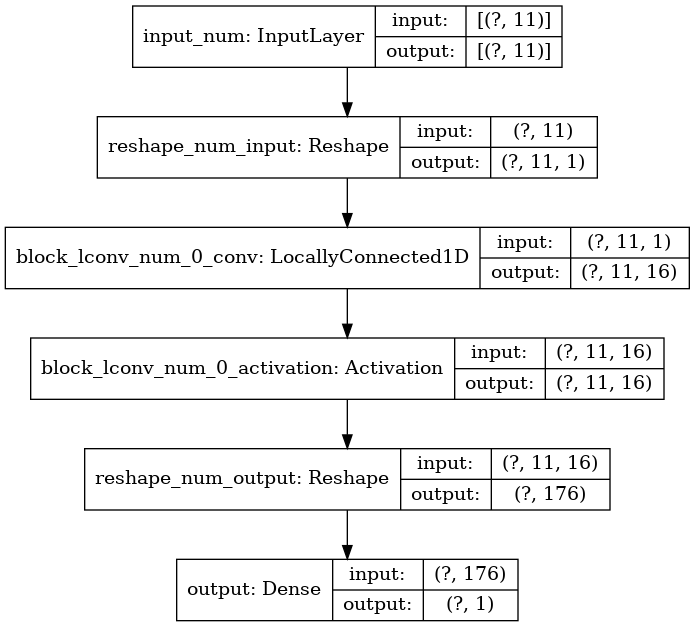

<IPython.core.display.Javascript object>

In [52]:
plot_model(
    model,
    # to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [53]:
y_train.shape

(120000,)

<IPython.core.display.Javascript object>

In [63]:
train["MonthlyIncome"]

0         0.288214
1         4.883764
2         0.022292
3        -0.000904
4        -0.102718
            ...   
149995    0.213695
149996         NaN
149997   -0.087716
149998   -0.047158
149999   -0.301830
Name: MonthlyIncome, Length: 150000, dtype: float64

<IPython.core.display.Javascript object>

In [54]:
input_model = []
input_valid = []
input_test = []

<IPython.core.display.Javascript object>

In [55]:
if INPUT_DIM_BOOL > 0:
    input_model.append(X_bool_train)
    input_valid.append(X_bool_valid)
    input_test.append(X_bool_test)
if INPUT_DIM_NUM > 0:
    #     input_model.append(X_num_train_preproc)
    #     input_valid.append(X_num_valid_preproc)
    #     input_test.append(X_num_test_preproc)
    input_model.append(X_num_train)
    input_valid.append(X_num_valid)
    input_test.append(X_num_test)

if INPUT_DIM > 0:
    input_model.append(X_train_preproc)
    input_valid.append(X_valid_preproc)
    input_test.append(X_test_preproc)

<IPython.core.display.Javascript object>

In [56]:
%%time
history = model.fit(
    input_model,
    y_train.reshape(-1, 1),
    epochs=2000,
    batch_size=1024,
    validation_data=(input_valid, y_valid.reshape(-1, 1),),
    verbose=1,
    callbacks=[EarlyStopping(monitor="val_loss", patience=20, verbose=1)],
)

Epoch 1/2000


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


118/118 [==============================] - 1s 13ms/step - loss: nan - val_loss: nan
Epoch 2/2000
118/118 [==============================] - 1s 9ms/step - loss: nan - val_loss: nan
Epoch 3/2000
118/118 [==============================] - 1s 10ms/step - loss: nan - val_loss: nan
Epoch 4/2000
118/118 [==============================] - 1s 6ms/step - loss: nan - val_loss: nan
Epoch 5/2000
118/118 [==============================] - 1s 6ms/step - loss: nan - val_loss: nan
Epoch 6/2000
118/118 [==============================] - 1s 6ms/step - loss: nan - val_loss: nan
Epoch 7/2000
118/118 [==============================] - 1s 6ms/step - loss: nan - val_loss: nan
Epoch 8/2000
118/118 [==============================] - 1s 5ms/step - loss: nan - val_loss: nan
Epoch 9/2000
118/118 [==============================] - 1s 5ms/step - loss: nan - val_loss: nan
Epoch 10/2000
118/118 [==============================] - 1s 4ms/step - loss: nan - val_loss: nan
Epoch 11/2000
118/118 [===========================

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

In [57]:
plot_history(history)

NameError: name 'history' is not defined

<IPython.core.display.Javascript object>

In [ ]:
model_auc = roc_auc_score(
    y_true=y_valid, y_score=model.predict(input_valid).reshape(-1),
)
model_auc

In [ ]:
# BM : 0.7847761386793823
# Census : 0.9461137700867462
# give me some credit : 0.8584216818313924

In [ ]:
model_auc = roc_auc_score(y_true=y_test, y_score=model.predict(input_test).reshape(-1),)
model_auc

In [ ]:
#  BM : 0.8091600443913225
# Census : 0.9467201048401863
# give me some credit : 0.8599316528022821

In [ ]:
# New version V3 => number are fillna, and activation is tanh instead of mish


In [ ]:
# NEW VERSION
# Bank marketing
# valid 0.7974101623084582 test 0.8133980360868731     conv_dim=[],    lconv_dim=[128, 64, 32],    lconv_num_dim=[64, 32, 16], patience 20
# RL
# valid 0.9334586431074957 test 0.9331843177543191     conv_dim=[],    lconv_dim=[128, 64, 32],    lconv_num_dim=[64, 32, 16], patience 20

In [ ]:
# Census example
# valid 0.9282381974389771 test 0.9262939626480025 conv_dim=[64], lconv_dim=[128, 64, 32] patience 50

# RL
# valid 0.9363136991351992 test 0.9431532242454923 conv_dim=[64], lconv_dim=[128, 64, 32] patience 50

# Open payments
# valid 0.9395366568006073 test 0.9370193221838594 conv_dim=[64], lconv_dim=[128, 64, 32] patience 50

# give-me-some-credit
# valid  test  conv_dim=[64], lconv_dim=[128, 64, 32] patience 50

In [ ]:
SAMPLE_NB = 1000

In [ ]:
if INPUT_DIM > 0:
    sample = X_valid_preproc[:SAMPLE_NB]
if INPUT_DIM_BOOL > 0:
    bool_sample = X_bool_valid[:SAMPLE_NB]
if INPUT_DIM_NUM > 0:
    num_sample = X_num_valid[:SAMPLE_NB]
input_sample = []

In [ ]:
if INPUT_DIM_BOOL > 0:
    input_sample.append(bool_sample)
if INPUT_DIM_NUM > 0:
    input_sample.append(num_sample)
if INPUT_DIM > 0:
    input_sample.append(sample)


In [ ]:
model_pred = model.predict(input_sample)
model_pred.shape

In [ ]:
model.layers[-2].output

In [ ]:
model.layers[-3].output

In [ ]:
new_model = Model(
    inputs=[model.inputs],
    outputs=[model.output, model.layers[-2].output, model.layers[-3].output],
)

In [ ]:
new_model_pred, feature_cat_inter, feature_num_inter = new_model.predict(input_sample)

In [ ]:
assert np.all(model_pred == new_model_pred)

In [ ]:
feature_cat_inter.shape

In [ ]:
feature_num_inter.shape

In [ ]:
# feature_inter.shape

In [ ]:
new_model.layers[-1]

In [ ]:
model.get_weights()[-2].shape

In [ ]:
model.layers[-2].output

In [ ]:
new_model = Model(inputs=[model.input], outputs=[model.layers[-2].output])

In [ ]:
%%time
new_train_logistic = new_model.predict(input_model)
new_valid_logistic = new_model.predict(input_valid)
new_test_logistic = new_model.predict(input_test)


In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [ ]:
lreg = LogisticRegression(max_iter=300, n_jobs=-1, random_state=SEED)

In [ ]:
%%time
lreg.fit(new_train_logistic, y_train.reshape(-1))

In [ ]:
roc_auc_score(
    y_true=y_valid, y_score=lreg.predict_proba(new_valid_logistic)[:, 1],
)

In [ ]:
#  BM : 0.7914463179718816
# give me some credit :0.8582349903898445

In [ ]:
roc_auc_score(
    y_true=y_test, y_score=lreg.predict_proba(new_test_logistic)[:, 1],
)

In [ ]:
# BM : 0.8097976507760546
# give me some credit :0.8593843699840211


roc_auc_score(
    y_true=y_test, y_score=lreg_cv.predict_proba(new_test_logistic)[:, 1],
)

In [ ]:
!pip install xgboost

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb = XGBClassifier(verbosity=1, tree_method="hist", seed=SEED,)

In [ ]:
train_indices = train[train.Set == "train"].index
valid_indices = train[train.Set == "valid"].index
test_indices = train[train.Set == "test"].index

In [ ]:
new_train_logistic.shape

In [ ]:
cat_cols = {}

In [ ]:
for col in used_columns:
    enc = LabelEncoder()
    train[col] = enc.fit_transform(train[col].values.astype("str").reshape(-1))
    cat_cols[col] = enc

In [ ]:
new_concat_train = np.hstack(
    [
        new_train_logistic,
        train[num_cols].values[train_indices],
        train[used_columns].values[train_indices],
    ]
)
new_concat_train.shape

In [ ]:
new_concat_valid = np.hstack(
    [
        new_valid_logistic,
        train[num_cols].values[valid_indices],
        train[used_columns].values[valid_indices],
    ]
)
new_concat_valid.shape

In [ ]:
new_concat_test = np.hstack(
    [
        new_test_logistic,
        train[num_cols].values[test_indices],
        train[used_columns].values[test_indices],
    ]
)
new_concat_test.shape

In [ ]:
xgb.fit(
    new_concat_train,
    y_train.reshape(-1),
    eval_set=[(new_concat_valid, y_valid.reshape(-1))],
    eval_metric="auc",
    early_stopping_rounds=20,
)

In [ ]:
roc_auc_score(
    y_true=y_valid, y_score=xgb.predict_proba(new_concat_valid)[:, 1],
)

In [ ]:
#  BM : 0.7950377112004379
# give me some credit :0.8608505974744193


In [ ]:
roc_auc_score(
    y_true=y_test, y_score=xgb.predict_proba(new_concat_test)[:, 1],
)

In [ ]:
#  BM : 0.8175536181491652
# give me some credit :0.8636238967612501

In [ ]:
stack_valid = (
    lreg.predict_proba(new_valid_logistic)[:, 1].reshape(-1)
    + xgb.predict_proba(new_concat_valid)[:, 1].reshape(-1)
    # + model.predict(input_valid).reshape(-1)
) / 2
stack_valid.shape

In [ ]:
roc_auc_score(
    y_true=y_valid, y_score=stack_valid,
)

In [ ]:
# BM 0.7989376973709024
# give me some credit :0.8620617468400065

In [ ]:
stack_test = (
    lreg.predict_proba(new_test_logistic)[:, 1].reshape(-1)
    + xgb.predict_proba(new_concat_test)[:, 1].reshape(-1)
    # + model.predict(input_test).reshape(-1)
) / 2
stack_test.shape

In [ ]:
roc_auc_score(
    y_true=y_test, y_score=stack_test,
)

In [ ]:
# BM 0.8212055857859865
# give me some credit :0.8640850442432623

In [ ]:
lreg.coef_

In [ ]:
model.get_weights()[-2]

In [ ]:
explainable_model = Model(
    inputs=[model.input], outputs=[model.output, model.layers[-3].output]
)

In [ ]:
preds, explainability = explainable_model.predict(input_sample)

In [ ]:
preds.shape

In [ ]:
explainability.shape

In [ ]:
model.get_weights()[-6].shape

In [ ]:
model.layers[-6].output

In [ ]:
model.layers[-7].output

In [ ]:
model.layers[-5]

In [ ]:
explainable_model = Model(
    inputs=[model.input],
    outputs=[
        model.output,
        model.layers[-5].output,
        model.layers[-7].output,
        model.layers[-6].output,
    ],
)

In [ ]:
preds, expl_boo, expl_num, expl_others = explainable_model.predict(input_sample)

In [ ]:
expl_num.shape

In [ ]:
preds

In [ ]:
model.get_weights()[-2].shape

In [ ]:
bool_weight = model.get_weights()[-2][:1]
bool_weight.shape

In [ ]:
num_weight = model.get_weights()[-2][1 : 9 * 16 + 1].reshape(-1, 16)
num_weight.shape

In [ ]:
others_weight = model.get_weights()[-2][9 * 16 + 1 :].reshape(-1, 32)
others_weight.shape

In [ ]:
expl_boo[0]

In [ ]:
expl_num[0].shape

In [ ]:
expl_others[0].shape

In [ ]:
1 + 9 * 16 + 9 * 32

In [ ]:
manual_pred = (
    expl_boo[0].reshape(-1) * bool_weight.reshape(-1)
    + (expl_num[0].reshape(-1) * num_weight.reshape(-1)).sum()
    + (expl_others[0].reshape(-1) * others_weight.reshape(-1)).sum()
) + model.layers[-1].get_weights()[1]
manual_pred

In [ ]:
from tensorflow.keras.activations import sigmoid

In [ ]:
assert np.isclose(sigmoid(manual_pred).numpy(), preds[0])

In [ ]:
model.layers[-1].get_weights()[1]

In [ ]:
all(model.get_weights()[-2] == model.layers[-1].get_weights()[0])

In [ ]:
expl_num[0].shape

In [ ]:
num_weight.shape

In [ ]:
features_explain = np.hstack(
    [
        (expl_boo * bool_weight).sum(axis=-1).reshape(-1, 1),
        (expl_num * num_weight).sum(-1),
        (expl_others * others_weight).sum(axis=-1),
    ]
)
features_explain.shape

In [ ]:
np.allclose(
    sigmoid(features_explain.sum(axis=1) + model.layers[-1].get_weights()[1]).numpy(),
    preds.reshape(-1),
)

In [ ]:
import matplotlib.pyplot as plt

# plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt


def explain_plot(importances, columns):
    # objects = ('Python', 'C++', 'Java', 'Perl', 'Scala', 'Lisp')
    y_pos = np.arange(importances.shape[0])
    indexes = np.argsort(importances)
    performance = importances[indexes]

    plt.barh(y_pos, performance, align="center", alpha=0.5)
    plt.yticks(y_pos, columns[indexes])
    # plt.xlabel('Usage')
    plt.title("Feature importance")

    plt.show()

In [ ]:
all_cols = np.array(bool_cols + num_cols.tolist() + used_columns)
all_cols

In [ ]:
explain_plot(np.abs(features_explain).sum(axis=0), all_cols)

In [ ]:
explain_plot(features_explain.sum(axis=0), all_cols)

In [ ]:
explain_plot(features_explain[10], all_cols)

In [ ]:
explain_plot(features_explain[0], all_cols)

In [ ]:
def sigmoid_derivate(x):
    return np.exp(-x) / (np.exp(-x) + 1) ** 2

In [ ]:
sigmoid_derivate(features_explain[10]).sum()

In [ ]:
sigmoid(features_explain[10])

In [ ]:
features_explain[0]

In [ ]:
explain_plot(features_explain[0], all_cols)

In [ ]:
for explanation in features_explain[:10]:
    explain_plot(explanation, all_cols)